In [1]:
## IMPORTS 
import evotoon
from data_classes import CatParam, IntParam, FloatParam

from scipy.stats import friedmanchisquare
import scikit_posthocs as sp

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import seaborn as sns#

import random

import warnings
warnings.filterwarnings("ignore")

## MAKE SEED
SEED = evotoon.make_seed(925)

In [2]:
folder_list = [
		'./InstanciasNKLandscapes/Instances-Testing/nk_2_20',
		'./InstanciasNKLandscapes/Instances-Testing/nk_2_38',
		'./InstanciasNKLandscapes/Instances-Testing/nk_2_52',
		'./InstanciasNKLandscapes/Instances-Testing/nk_3_20',
		'./InstanciasNKLandscapes/Instances-Testing/nk_3_34',
		'./InstanciasNKLandscapes/Instances-Testing/nk_3_48',
		'./InstanciasNKLandscapes/Instances-Testing/nk_4_20',
		'./InstanciasNKLandscapes/Instances-Testing/nk_4_30',
		'./InstanciasNKLandscapes/Instances-Testing/nk_4_40',
		'./InstanciasNKLandscapes/Instances-Testing/nk_5_20',
		'./InstanciasNKLandscapes/Instances-Testing/nk_5_28',
		'./InstanciasNKLandscapes/Instances-Testing/nk_5_38',
		'./InstanciasNKLandscapes/Instances-Testing/nk_6_20',
		'./InstanciasNKLandscapes/Instances-Testing/nk_6_26',
		'./InstanciasNKLandscapes/Instances-Testing/nk_6_32'
 ]

In [3]:
def get_best_confs(folder):
	cols = ["p_c", "p_m", "N", "c_0", "Step_Found", "VALUE"]

	df = pd.DataFrame()
	for file in sorted(os.listdir(folder)):
		path = folder + file
		df = df.append(pd.read_csv(path, usecols= cols, sep='\t').iloc[0])

	return df.reset_index(drop=True)

def run_ga(save_folder, ins_folder, seed, p_c, p_m, N, c_0, t_max):
	instance_list = []
	for file in sorted(os.listdir(ins_folder)):
		file_path = os.path.join(ins_folder, file)
		instance_list.append(file_path)

	output = "lol.txt"
	if not os.path.exists(save_folder):
		os.makedirs(save_folder)
	f = open(save_folder+"/"+ins_folder.split("/")[-1]+"-"+str(seed)+".txt", "a")
	for file in instance_list:
		out = evotoon.execute_CodGA(file, seed, "./CodGA/ga-nk", p_c, p_m, N, t_max, c_0, output) * -1
		f.write(str(out)+"\n")
	f.close()

def get_evaluations(folder):
	all_lines = []
	indexes = []
	for file in os.listdir(folder):
		file_path = os.path.join(folder, file)
		f = open(file_path, "r")
		lines = f.readlines()
		all_lines = all_lines + [float(line.rstrip("\n")) for line in lines]
		indexes = indexes + [f"{file}_{i}" for i, line in enumerate(lines)]
	return pd.Series(all_lines, index=indexes)

def get_results_df(folder):
	cols = ["SEED " + str(i) for i in range(SEED, SEED+5)]
	dict_y = {}

	df = pd.DataFrame()
	for i in range(1,6):
		path = f"./codgatesting/{folder}/{i}"
		for file in sorted(os.listdir(path)):
			file_path = os.path.join(path, file)
			f = open(file_path, "r")
			lines = f.readlines()
			lines = [float(line.rstrip("\n")) for line in lines]
			mean = sum(lines)/len(lines)
			row_name, seed = file.split("-")[0], file.split("-")[1].split(".")[0]
			if not dict_y.get(row_name):
				dict_y[row_name] = {}
			dict_y[row_name][seed] = mean
			f.close()

		df_y = pd.DataFrame.from_dict(dict_y, orient='index')
		df[i] = df_y.mean(axis=1)

	df.loc["Promedio"] = df.mean()
	df.loc["Mediana"] = df.median()
	df.loc["Desviación"] = df.std()
	df = df.round(1)
	return df

In [26]:
def rank_executions(path, seed=SEED):
	df = pd.DataFrame()
	exec_folders = sorted([file for file in os.listdir(path) if ".txt" not in file], key=float)
	for folder in exec_folders:
		df = pd.concat([df, get_evaluations(path+folder)], axis=1)

	df.columns = exec_folders
	df = df.dropna()
	df_sample = df.sample(int(df.shape[0] * 0.1), random_state=seed)
	df = df_sample.rank(axis=1, numeric_only=True)
	return df

def boxplot_executions(df, xlabel, xrotate):
	x = df.columns
	y = [df[a] for a in df]
	if xrotate:
		plt.xticks(rotation=90)
	plt.boxplot(y, labels=x, patch_artist=True, showfliers=False)
	plt.rcParams["figure.figsize"] = (24,6)
	plt.xlabel(xlabel)
	plt.ylabel("Rank")
	a = plt.boxplot(y, labels=x, patch_artist=True, showfliers=False)

	for label, box in zip(x,a["boxes"]):
		box.set_facecolor("darkgray")

	for median in a['medians']:
		median.set_color('white')
		
	return plt


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/site-packages/matplotlib/pyplot.py'>

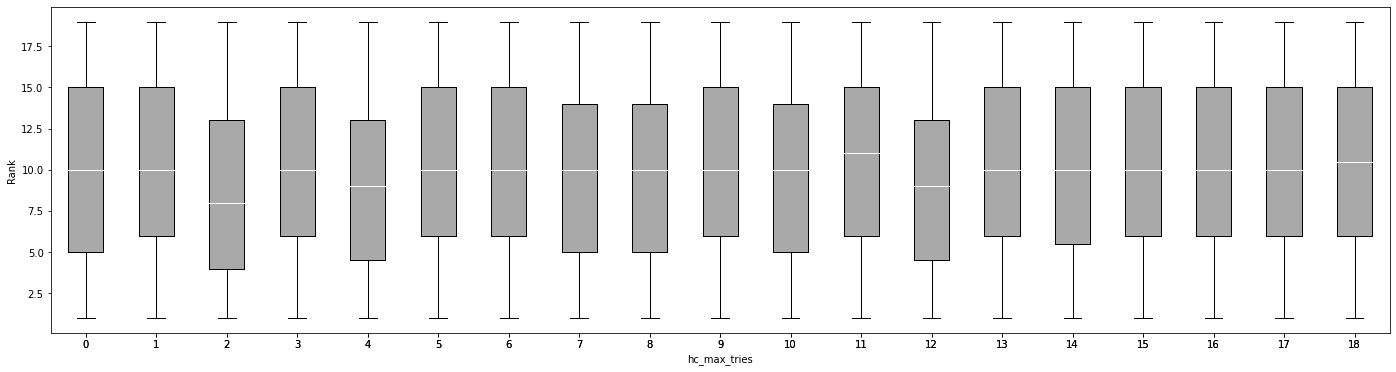

In [27]:
df = rank_executions("./codga_hc_max_tries_exp/", SEED)
boxplot_executions(df, "hc_max_tries", False)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/site-packages/matplotlib/pyplot.py'>

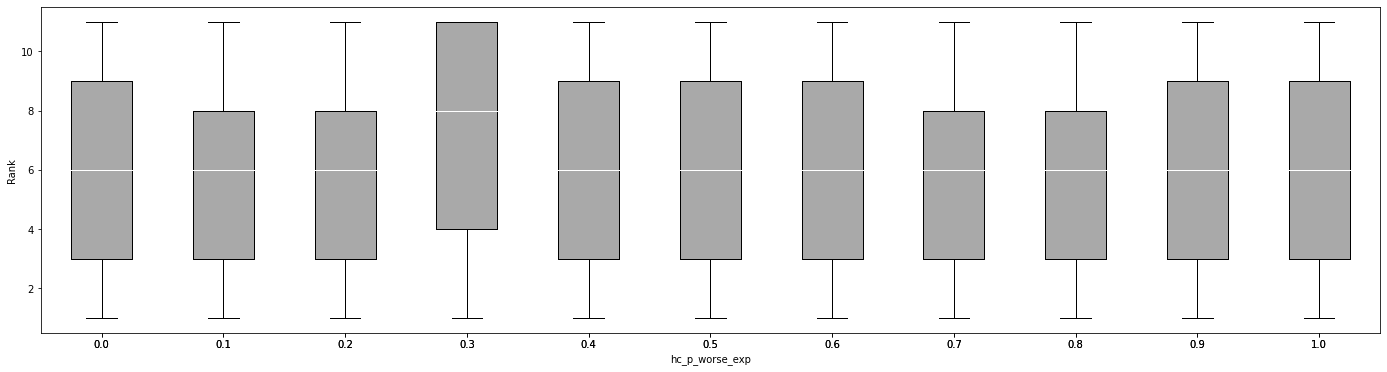

In [32]:
df = rank_executions("./codga_hc_p_worse_exp/", SEED)
boxplot_executions(df, "hc_p_worse_exp", False)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/site-packages/matplotlib/pyplot.py'>

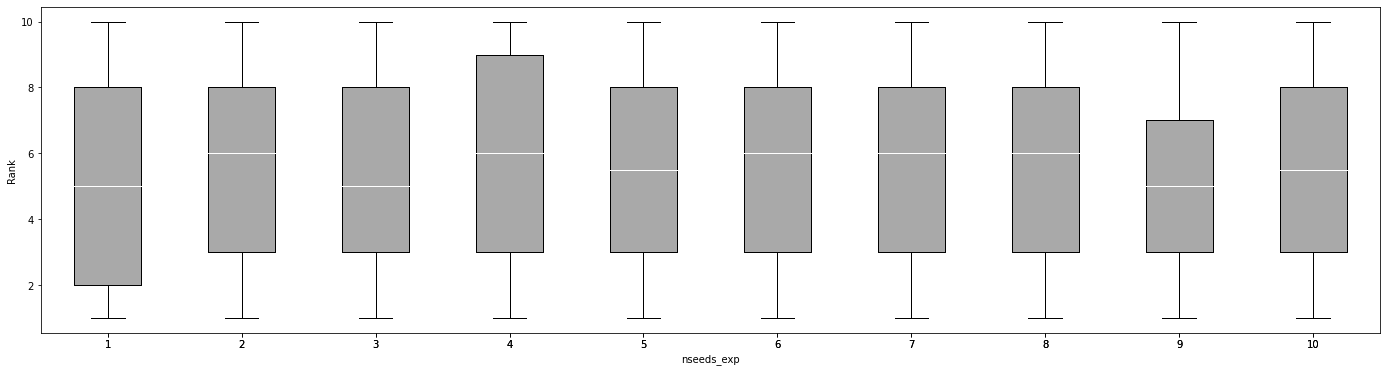

In [33]:
df = rank_executions("./codga_nseeds_exp/", SEED)
boxplot_executions(df, "nseeds_exp", False)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/site-packages/matplotlib/pyplot.py'>

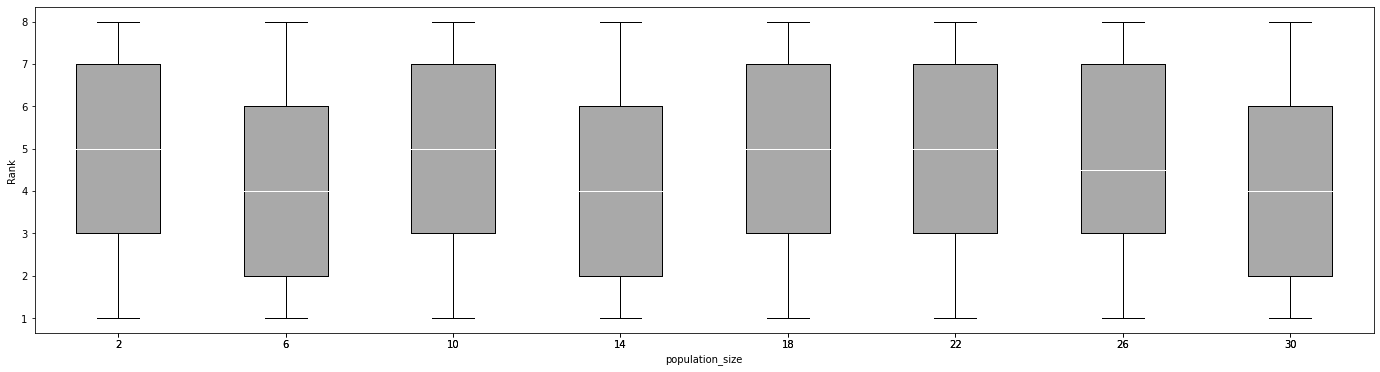

In [34]:
df = rank_executions("./codga_population_exp/", SEED)
boxplot_executions(df, "population_size", False)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/site-packages/matplotlib/pyplot.py'>

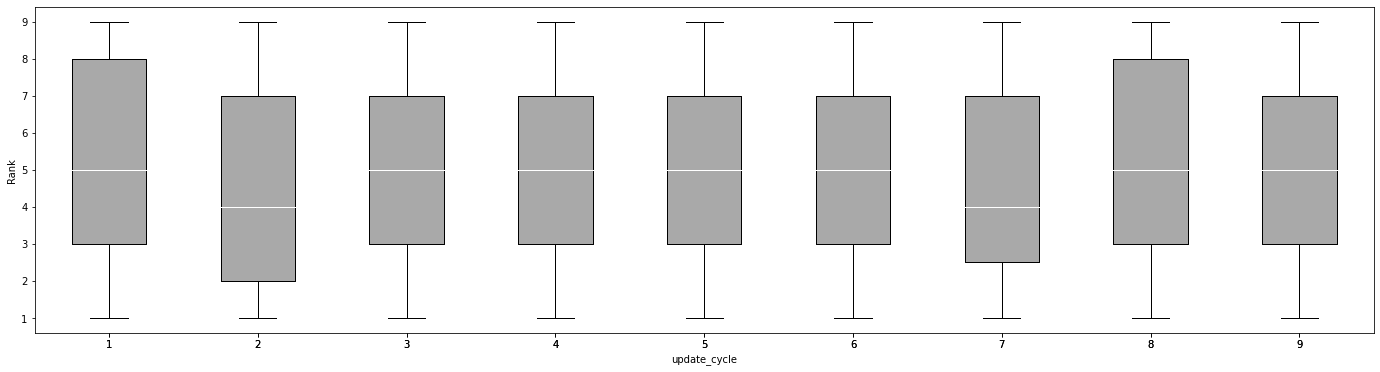

In [35]:
df = rank_executions("./codga_updatecycle_exp/", SEED)
boxplot_executions(df, "update_cycle", False)